# Setup

In [1]:
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import rrule
import datetime as dt

# Pre-analysis

## Import data

In [2]:
# Read csv-file
df = pd.read_csv("Data_Boliga_20220208_cleaned.csv")

n_rows, n_cols = df.shape
print('Number of rows: {}'.format(n_rows))
print('Number of columns: {}'.format(n_cols))

Number of rows: 54793
Number of columns: 13


Check first rows and data types

In [3]:
df.head()

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5000000,17-01-2022,Alm. Salg,93,53763,3,2007,-5,2100,København Ø
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8495000,14-01-2022,Alm. Salg,170,49971,6,1929,0,2100,København Ø
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5400000,14-01-2022,Alm. Salg,105,51429,3,1863,-2,2200,København N
3,E,"Badensgade 48, 2",2300 København S,7200000,14-01-2022,Alm. Salg,65,110769,3,1899,0,2300,København S
4,E,"Badensgade 48, 1",2300 København S,7200000,14-01-2022,Alm. Salg,79,91139,3,1899,0,2300,København S


In [4]:
df.dtypes

Type             object
StreetAddress    object
Area             object
Price             int64
Date             object
SellType         object
Size              int64
Price_m2          int64
Rooms             int64
YearBuilt         int64
PriceChange       int64
PostalCode        int64
AreaName         object
dtype: object

Check number of house types and how it was sold
<br>
<br>
E - apartment
<br>
R - terrace house
<br>
V - villa
<br>
<br>
Alm. Salg - sold on the open market
<br>
Andet - other
<br>
Auktion - auction
<br>
Fam. Salg - sold within family

In [5]:
# Check number of house types sold
print(df.groupby('Type').size())

print(df.groupby('SellType').size())


Type
E    47475
R     3099
V     4219
dtype: int64
SellType
Alm. Salg    47410
Andet         2040
Auktion         49
Fam. Salg     5294
dtype: int64


### Filter data
The main interest is apartments, hence filter out observations which are villas or terrace houses. I also filter out sales that has not been on the open market, since sales within families or auctions might distort the data.

In [6]:
mask = ((df['Type'] == 'E') & (df['SellType'] == 'Alm. Salg'))
df = df[mask].copy()

print(df.shape)

(40673, 13)


Inspect the data with some initial analysis of summary statistics and histograms. Comment about postal code
<br>
<br>
The summary statistics and histograms reveal that there probably are some outliers/bad observations in the data, e.g. the biggest apartment that has been sold is 857 m2, the maximum number of rooms is 13 and the oldest house is built at Year 0. 

In [7]:
df.describe()

,Price,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode
count,4.067300e+04,40673.000000,4.067300e+04,40673.000000,40673.000000,40673.000000,40673.000000
mean,6.110597e+06,84.081528,8.375171e+04,2.828879,1909.852212,-1.215696,2201.134463
std,8.870159e+06,36.692984,1.798071e+05,1.142108,247.538151,4.237192,379.485450
min,5.119900e+04,12.000000,4.570000e+02,1.000000,0.000000,-99.000000,1050.000000
25%,2.225000e+06,58.000000,3.423900e+04,2.000000,1904.000000,-2.000000,2100.000000
50%,3.400000e+06,76.000000,4.210500e+04,3.000000,1935.000000,0.000000,2300.000000
75%,5.275000e+06,102.000000,5.253600e+04,3.000000,1975.000000,0.000000,2450.000000
max,8.500000e+07,857.000000,4.083333e+06,13.000000,2021.000000,249.000000,2900.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Price_m2'}>],
       [<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'PriceChange'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

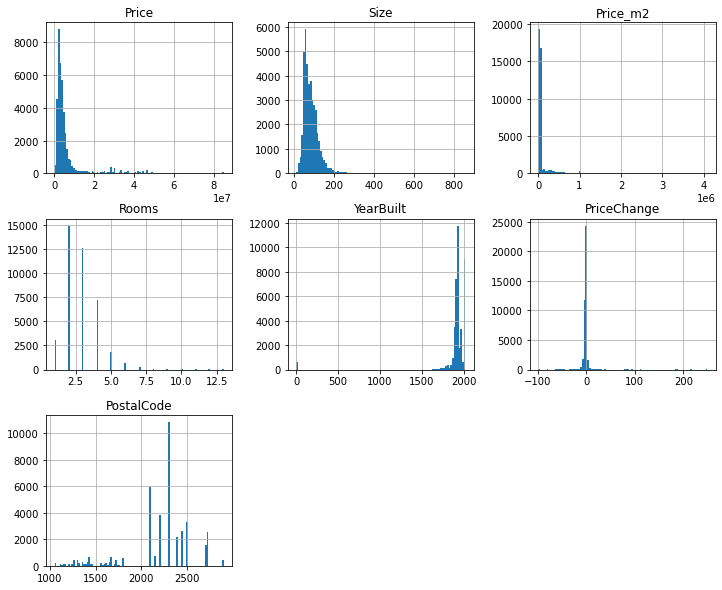

In [8]:
df.hist(bins=100, figsize=(12,10))

### Price adjustment
Dealing with prices from different years, there is a need to adjust these to the inflation. I collected Danish inflation data from Statistics Denmar (link).

In [9]:
df_inf = pd.read_csv("DST_Inflation_2015_2022.csv", header = None)

df_inf.head()

,0,1,2
0,,2015M01,98.9
1,,2015M02,99.7
2,,2015M03,100.2
3,,2015M04,100.4
4,,2015M05,100.4


Name the columns of the data frame and split the column, (1), containing year and month into two, so that it can be joined to the data frame with observations.

In [10]:
df_inf.drop(0, axis = 1, inplace = True)

df_inf.columns = ['YearMonth','Index']

df_inf[['Year', 'Month']] = df_inf['YearMonth'].str.split('M', expand = True).astype(int)

df_inf.drop('YearMonth', axis = 1, inplace = True)

df_inf.head()

,Index,Year,Month
0,98.9,2015,1
1,99.7,2015,2
2,100.2,2015,3
3,100.4,2015,4
4,100.4,2015,5


Join data frame with inflation index to data frame with prices and calculate adjusted the prices.

In [11]:
# Make date column into date format
df['Date_dt'] = pd.to_datetime(df['Date'], format =  "%d-%m-%Y")

df['Date_Year']  = df['Date_dt'].dt.year
df['Date_Month'] = df['Date_dt'].dt.month
df['Date_Week'] = df['Date_dt'].dt.week


C:\Users\marti\AppData\Local\Temp/ipykernel_20416/4020766101.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Date_Week'] = df['Date_dt'].dt.week


In [12]:
# Join data frames
df = df.merge(df_inf,
         how = 'left',
         left_on = ['Date_Year','Date_Month'],
         right_on = ['Year', 'Month']
        )

# Calculate adjusted prices
df['Price_2015'] = (df['Price'] * df['Index']/100).astype(int)
df['Price_m2_2015'] = (df['Price_m2'] * df['Index']/100).astype(int)

df.head()


,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,...,AreaName,Date_dt,Date_Year,Date_Month,Date_Week,Index,Year,Month,Price_2015,Price_m2_2015
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5000000,17-01-2022,Alm. Salg,93,53763,3,2007,...,København Ø,2022-01-17,2022,1,3,108.0,2022,1,5400000,58064
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8495000,14-01-2022,Alm. Salg,170,49971,6,1929,...,København Ø,2022-01-14,2022,1,2,108.0,2022,1,9174600,53968
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5400000,14-01-2022,Alm. Salg,105,51429,3,1863,...,København N,2022-01-14,2022,1,2,108.0,2022,1,5832000,55543
3,E,"Badensgade 48, 2",2300 København S,7200000,14-01-2022,Alm. Salg,65,110769,3,1899,...,København S,2022-01-14,2022,1,2,108.0,2022,1,7776000,119630
4,E,"Badensgade 48, 1",2300 København S,7200000,14-01-2022,Alm. Salg,79,91139,3,1899,...,København S,2022-01-14,2022,1,2,108.0,2022,1,7776000,98430


Check that no NaN has been introduced

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40673 entries, 0 to 40672
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Type           40673 non-null  object        
 1   StreetAddress  40673 non-null  object        
 2   Area           40673 non-null  object        
 3   Price          40673 non-null  int64         
 4   Date           40673 non-null  object        
 5   SellType       40673 non-null  object        
 6   Size           40673 non-null  int64         
 7   Price_m2       40673 non-null  int64         
 8   Rooms          40673 non-null  int64         
 9   YearBuilt      40673 non-null  int64         
 10  PriceChange    40673 non-null  int64         
 11  PostalCode     40673 non-null  int64         
 12  AreaName       40673 non-null  object        
 13  Date_dt        40673 non-null  datetime64[ns]
 14  Date_Year      40673 non-null  int64         
 15  Date_Month     4067

### Age

<AxesSubplot:xlabel='Age', ylabel='Count'>

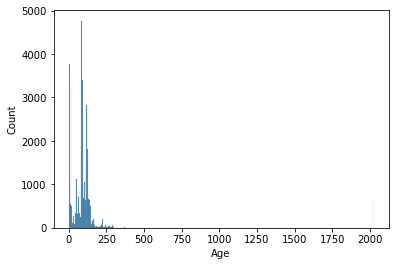

In [14]:
df['Age'] = 2022 - df['YearBuilt']

sns.histplot(data = df, x = 'Age')

In [15]:
df[df['Age'] > 1000]['StreetAddress'].unique()

array(['Monica Zetterlunds Vej 3, 2. 3', 'Drechselsgade 18, 1. 4',
       'Monica Zetterlunds Vej 3, 3. 2',
       'Monica Zetterlunds Vej 17, 3. th',
       'Monica Zetterlunds Vej 13, 1. th',
       'Monica Zetterlunds Vej 3, 3. 3', 'Bjerregårdsvej 12A, 1',
       'Bjerregårdsvej 12', 'Willy Brandts Vej 23, 4. 4',
       'Monica Zetterlunds Vej 15, st. th',
       'Monica Zetterlunds Vej 21, 1. th',
       'Monica Zetterlunds Vej 25, st. tv', 'Willy Brandts Vej 25, 4. 4',
       'Drechselsgade 18, 10. tv', 'Sundkaj 109, st. th',
       'Willy Brandts Vej 25, 5', 'Drechselsgade 18, 5. th',
       'Sundkaj 109, 2. tv', 'Drechselsgade 10C',
       'Drechselsgade 12, 6. tv', 'Monica Zetterlunds Vej 3, 2. 2',
       'Drechselsgade 10D', 'Drechselsgade 12, 10. th',
       'Monica Zetterlunds Vej 9, 1. tv',
       'Monica Zetterlunds Vej 17, 5. th', 'Willy Brandts Vej 25, 3. 3',
       'Monica Zetterlunds Vej 21, st. mf', 'Sundkaj 101, st. th',
       'Monica Zetterlunds Vej 17, 6. th', 'Dr

In [16]:
df.loc[df['Age'] > 1000, 'Age'] =  np.random.choice(np.arange(0,10,1))



,Price,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,Date_Year,Date_Month,Date_Week,Index,Year,Month,Price_2015,Price_m2_2015,Age
count,4.067300e+04,40673.000000,4.067300e+04,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,4.067300e+04,4.067300e+04,40673.000000
mean,6.110597e+06,84.081528,8.375171e+04,2.828879,1909.852212,-1.215696,2201.134463,2018.294274,6.337152,25.868930,102.050134,2018.294274,6.337152,6.220678e+06,8.524006e+04,80.247461
std,8.870159e+06,36.692984,1.798071e+05,1.142108,247.538151,4.237192,379.485450,1.997311,3.416964,14.921958,1.665575,1.997311,3.416964,8.973685e+06,1.818586e+05,53.635903
min,5.119900e+04,12.000000,4.570000e+02,1.000000,0.000000,-99.000000,1050.000000,2015.000000,1.000000,1.000000,98.900000,2015.000000,1.000000,5.186400e+04,4.680000e+02,1.000000
25%,2.225000e+06,58.000000,3.423900e+04,2.000000,1904.000000,-2.000000,2100.000000,2017.000000,3.000000,13.000000,100.600000,2017.000000,3.000000,2.276175e+06,3.485500e+04,33.000000
50%,3.400000e+06,76.000000,4.210500e+04,3.000000,1935.000000,0.000000,2300.000000,2018.000000,6.000000,26.000000,102.300000,2018.000000,6.000000,3.481530e+06,4.307300e+04,87.000000
75%,5.275000e+06,102.000000,5.253600e+04,3.000000,1975.000000,0.000000,2450.000000,2020.000000,9.000000,39.000000,103.000000,2020.000000,9.000000,5.398597e+06,5.407500e+04,117.000000
max,8.500000e+07,857.000000,4.083333e+06,13.000000,2021.000000,249.000000,2900.000000,2022.000000,12.000000,53.000000,108.000000,2022.000000,12.000000,8.500000e+07,4.156832e+06,399.000000


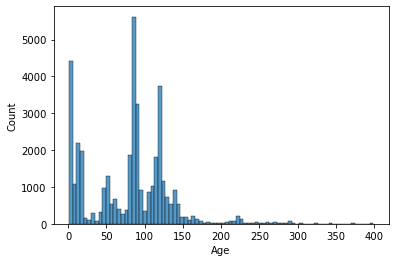

In [17]:
sns.histplot(data = df, x = 'Age')
df.describe()

### Filter out outliers

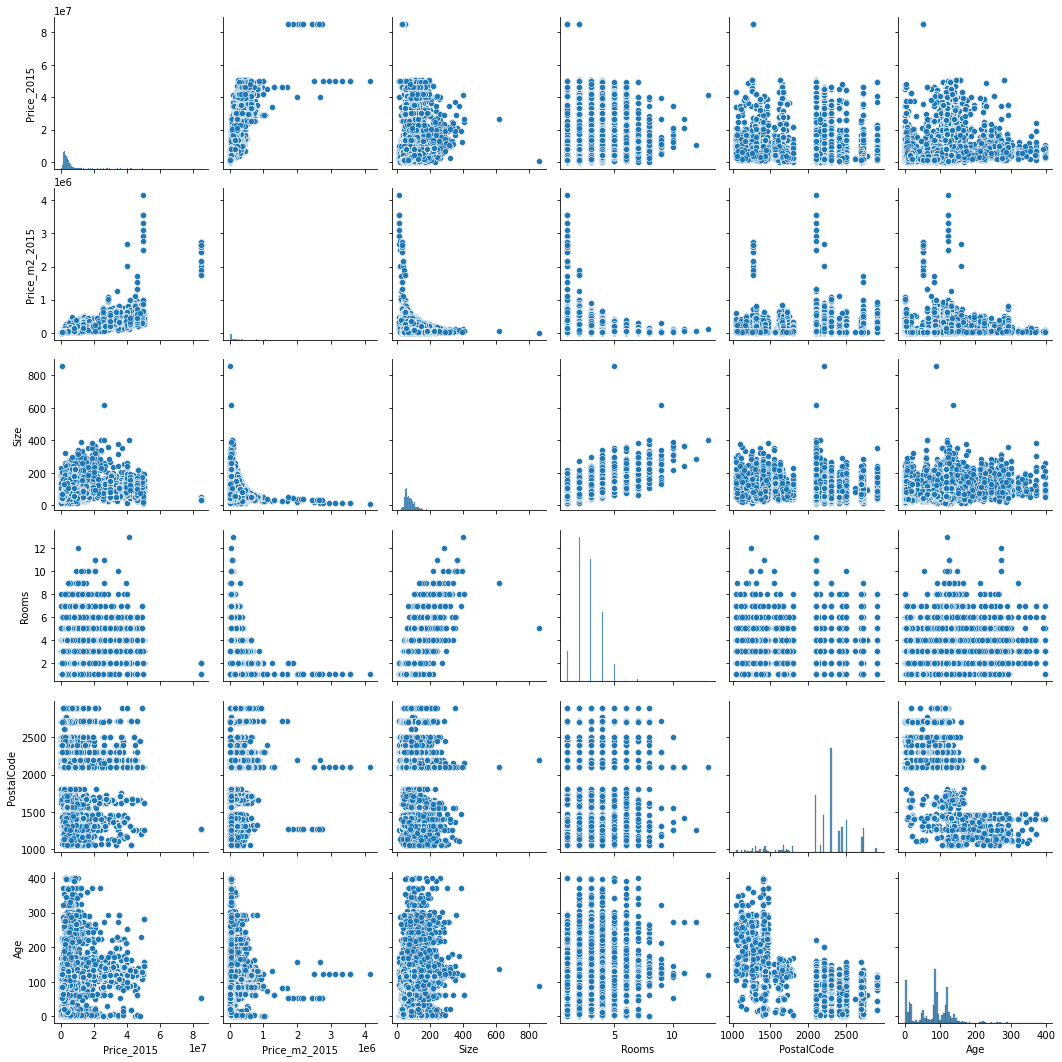

In [18]:
l_cols_pp = ['Price_2015','Price_m2_2015', 'Size', 'Rooms', 'PostalCode', 'Age']

sns.pairplot(df[l_cols_pp])

There seems to be some outliers with regards to size and price

In [19]:
df[df['Size']> 600]

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,...,Date_dt,Date_Year,Date_Month,Date_Week,Index,Year,Month,Price_2015,Price_m2_2015,Age
1821,E,"Dag Hammarskjölds Allé 42D, 4",2100 København Ø,25000000,19-08-2021,Alm. Salg,616,40584,9,1886,...,2021-08-19,2021,8,33,105.0,2021,8,26250000,42613,136
12915,E,"Rådmandsgade 60, 1",2200 København N,720000,18-03-2020,Alm. Salg,857,840,5,1934,...,2020-03-18,2020,3,12,102.7,2020,3,739440,862,88


In [20]:
df[df['Price'] > 60000000]

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,...,Date_dt,Date_Year,Date_Month,Date_Week,Index,Year,Month,Price_2015,Price_m2_2015,Age
31057,E,"Store Kongensgade 100, 5. 13",1264 København K,85000000,16-01-2017,Alm. Salg,31,2741936,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2741936,52
31058,E,"Store Kongensgade 100, 3. 4",1264 København K,85000000,16-01-2017,Alm. Salg,39,2179487,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2179487,52
31059,E,"Store Kongensgade 100, 5. 8",1264 København K,85000000,16-01-2017,Alm. Salg,32,2656250,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2656250,52
31060,E,"Store Kongensgade 100, 3. 5",1264 København K,85000000,16-01-2017,Alm. Salg,33,2575758,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2575758,52
31061,E,"Store Kongensgade 100, 2. 2",1264 København K,85000000,16-01-2017,Alm. Salg,32,2656250,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2656250,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31124,E,"Store Kongensgade 100, 2. 11",1264 København K,85000000,16-01-2017,Alm. Salg,33,2575758,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2575758,52
31125,E,"Store Kongensgade 100, 6. 2",1264 København K,85000000,16-01-2017,Alm. Salg,39,2179487,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2179487,52
31126,E,"Store Kongensgade 100, 2. 6",1264 København K,85000000,16-01-2017,Alm. Salg,32,2656250,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2656250,52
31127,E,"Store Kongensgade 100, 3. 13",1264 København K,85000000,16-01-2017,Alm. Salg,31,2741936,1,1970,...,2017-01-16,2017,1,3,100.0,2017,1,85000000,2741936,52


In [21]:
df = df[(df['Price'] <60000000) & (df['Size'] <600)]

Filter out observations which are part of larger investments

In [78]:
df['Street'] = df['StreetAddress'].str.split(',').str[0]



df_mult_out = df.groupby(['Price', 'Date', 'Street'])['Price'].size().sort_values(ascending = False).reset_index(name = 'Count')


df_mult_out.head(10)

,Price,Date,Street,Count
0,8350000,02-01-2015,Esromgade 26,184
1,28101990,14-08-2018,Amagerfælledvej 62A,118
2,28101990,14-08-2018,Amagerfælledvej 62B,115
3,28101990,14-08-2018,Amagerfælledvej 62C,104
4,30500000,07-01-2015,Lergravsvej 36,57
5,3995000,06-03-2018,Husumgade 12,38
6,25500000,01-10-2015,Strandlodsvej 5A,37
7,30500000,07-01-2015,Lergravsvej 32,35
8,30500000,07-01-2015,Lergravsvej 34,35
9,14500000,16-05-2019,Spaniensgade 11,34


In [87]:
df_mult_out[df_mult_out['Count'] >=2]['Count'].sum()

7141

In [109]:
df_2 = df.merge(
    df_mult_out[df_mult_out['Count'] >=2],
    how = 'left',
    on = ['Price', 'Date', 'Street']
)

df_2 = df_2[df_2['Count'].isnull()]

df_2

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,...,Date_Month,Date_Week,Index,Year,Month,Price_2015,Price_m2_2015,Age,Street,Count
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5000000,17-01-2022,Alm. Salg,93,53763,3,2007,...,1,3,108.0,2022,1,5400000,58064,15,Amerika Plads 6,NaN
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8495000,14-01-2022,Alm. Salg,170,49971,6,1929,...,1,2,108.0,2022,1,9174600,53968,93,Strandvejen 8,NaN
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5400000,14-01-2022,Alm. Salg,105,51429,3,1863,...,1,2,108.0,2022,1,5832000,55543,159,Nørrebrogade 9F,NaN
6,E,"Nattergalevej 52, 1. tv",2400 København NV,2895000,14-01-2022,Alm. Salg,54,53611,2,1937,...,1,2,108.0,2022,1,3126600,57899,85,Nattergalevej 52,NaN
7,E,"Sorrentovej 14, 1. tv",2300 København S,2330000,14-01-2022,Alm. Salg,52,44808,2,1940,...,1,2,108.0,2022,1,2516400,48392,82,Sorrentovej 14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39897,E,"Rundholtsvej 26, st. 2",2300 København S,3495000,07-01-2015,Alm. Salg,112,31205,3,2014,...,1,2,98.9,2015,1,3456555,30861,8,Rundholtsvej 26,NaN
39898,E,"Sandkaj 37, st. tv",2150 Nordhavn,5495000,07-01-2015,Alm. Salg,111,49505,3,2017,...,1,2,98.9,2015,1,5434555,48960,5,Sandkaj 37,NaN
39909,E,"Store Kongensgade 49, 2. 2",1264 København K,3500000,07-01-2015,Alm. Salg,82,42683,2,1935,...,1,2,98.9,2015,1,3461500,42213,87,Store Kongensgade 49,NaN
39910,E,"Store Strandstræde 10, 2",1255 København K,5500000,07-01-2015,Alm. Salg,161,34161,4,1690,...,1,2,98.9,2015,1,5439500,33785,332,Store Strandstræde 10,NaN


### Split data

In [113]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_2, test_size=0.2, random_state=42)

# Exploratory analysis

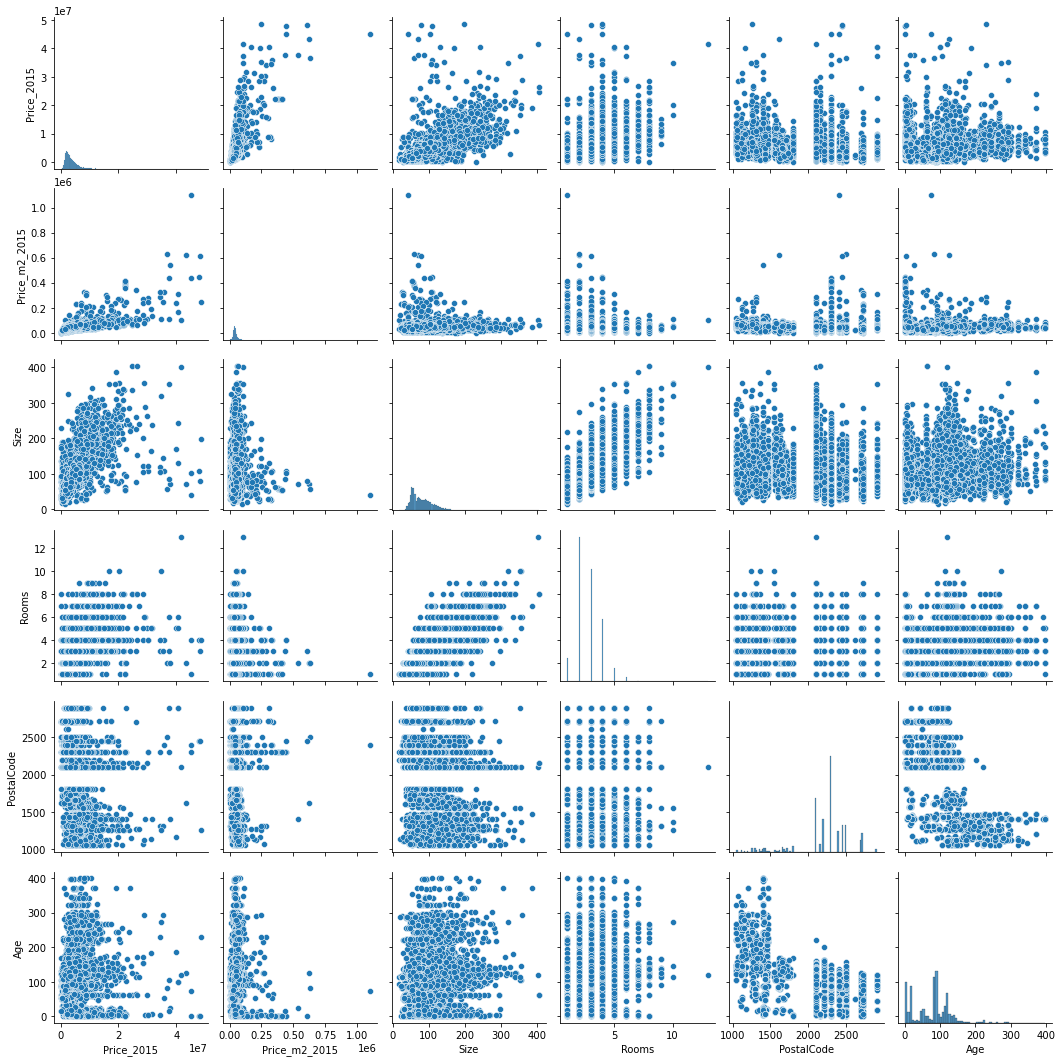

In [114]:
l_cols_pp = ['Price_2015', 'Price_m2_2015', 'Size', 'Rooms','PostalCode', 'Age']

sns.pairplot(df_train[l_cols_pp])

In [115]:
df_train[l_cols_pp].corr()['Price_2015']

Price_2015       1.000000
Price_m2_2015    0.671532
Size             0.747317
Rooms            0.584588
PostalCode      -0.318080
Age              0.006655
Name: Price_2015, dtype: float64

<AxesSubplot:xlabel='Size', ylabel='Price_2015'>

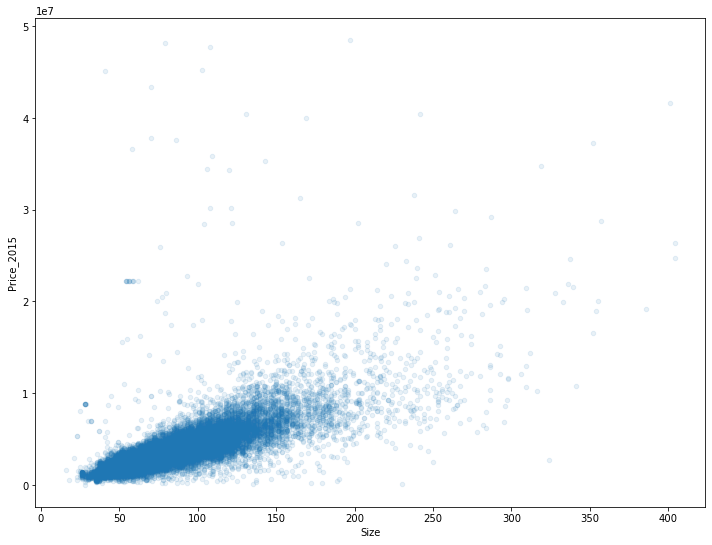

In [116]:
df_train.plot(kind = "scatter", x = 'Size', y = 'Price_2015', alpha =0.1, figsize = (12,9))

<AxesSubplot:xlabel='Rooms', ylabel='Price_2015'>

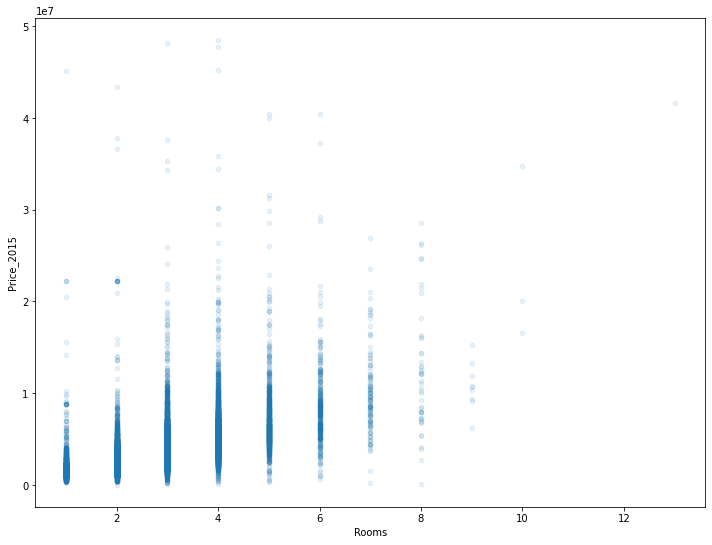

In [127]:
df_train.plot(kind = "scatter", x = 'Rooms', y = 'Price_2015', alpha =0.1, figsize = (12,9))

<AxesSubplot:xlabel='PostalCode', ylabel='Price_2015'>

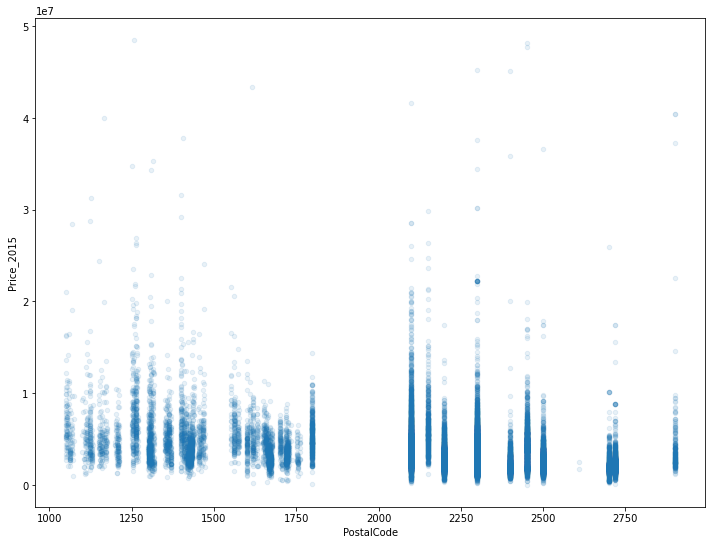

In [117]:
df_train.plot(kind = "scatter", x = 'PostalCode', y = 'Price_2015', alpha =0.1, figsize = (12,9))

<AxesSubplot:xlabel='Age', ylabel='Price_2015'>

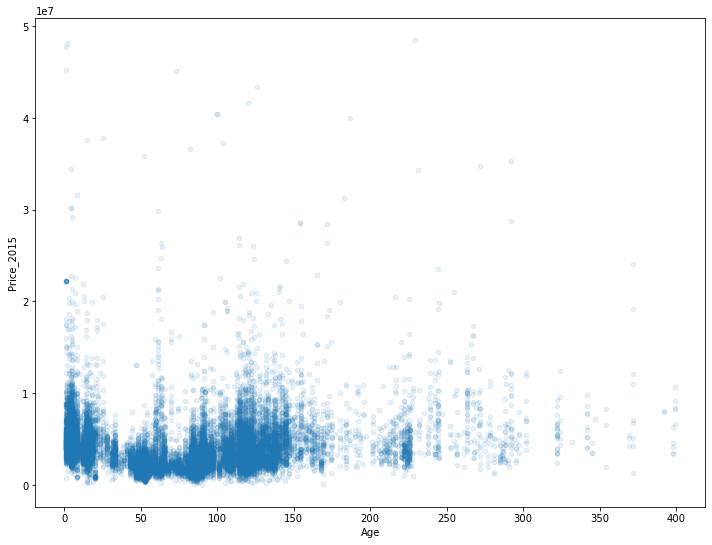

In [118]:
df_train.plot(kind = "scatter", x = 'Age', y = 'Price_2015', alpha =0.1, figsize = (12,9))

# First model

## Model

In [120]:
from sklearn.linear_model import LinearRegression

X_cols = ['Size', 'Rooms', 'Age']
Y_cols = ['Price_2015']



In [139]:
lin_reg = LinearRegression()

df_train_X = df_train[X_cols].copy()
df_train_Y = df_train[Y_cols].copy()

df_train_X

#lin_reg.fit(df_train_X, df_train_Y)

,Size,Rooms,Age
38166,122,4,32
37579,55,2,110
8167,154,6,20
30860,61,2,116
40,98,4,108
...,...,...,...
19153,31,1,52
6999,102,2,244
12571,63,2,117
935,45,1,8


In [122]:
from sklearn.metrics import mean_squared_error

Y_pred = lin_reg.predict(df_train_X)
lin_mse = mean_squared_error(Y_pred, df_train_Y)
#print(lin_mse)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

2923092532947.389
1709705.393612417


<AxesSubplot:xlabel='Price_2015', ylabel='Y_pred'>

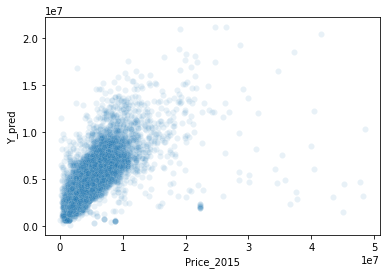

In [124]:

df_results = df_train_X.copy()
df_results['Y_pred'] = Y_pred
df_results['Price_2015'] = df_train_Y
df_results['Y_pred_diff'] = df_results['Y_pred'] - df_results['Price_2015']


sns.scatterplot(data = df_results, x = 'Price_2015', y = 'Y_pred', alpha = 0.1)

<AxesSubplot:xlabel='Price_2015', ylabel='Y_pred_diff'>

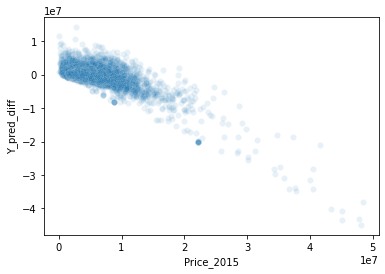

In [125]:
sns.scatterplot(data = df_results, x = 'Price_2015', y = 'Y_pred_diff', alpha = 0.1)

<AxesSubplot:xlabel='Size', ylabel='Y_pred_diff'>

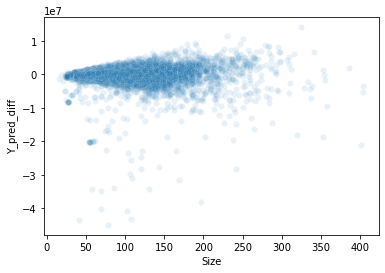

In [131]:
sns.scatterplot(data = df_results, x = 'Size', y = 'Y_pred_diff', alpha = 0.1)

# Second model
Standardise values

## Preparations - transformations

In [133]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Pipeline_m2 = Pipeline([
    ('std_scl', StandardScaler())
])




In [141]:
df_train_X = Pipeline_m2.fit_transform(df_train[X_cols])

df_train_X
lin_reg_2 = LinearRegression()
lin_reg_2.fit(df_train_X, df_train_Y)

LinearRegression()

In [142]:
Y_pred = lin_reg_2.predict(df_train_X)
lin_mse = mean_squared_error(Y_pred, df_train_Y)
#print(lin_mse)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

1709705.393612417


# Old

In [49]:
df_ym_AvgP.tail(20)

Date_Year  Date_Week
2021       44           47230.868750
           45           86706.569767
           46           46607.317073
           47           44476.821918
           48           48503.750000
           49           51320.137615
           50           45761.473684
           51           51328.322581
           52           36074.769231
           53           49300.121212
2022       2            57861.272727
           3            53763.000000
           9            45765.666667
           13           33333.000000
           17           52688.750000
           22           31349.000000
           26           53042.500000
           39           44928.000000
           44           37991.333333
           48           37729.666667
Name: Price_m2, dtype: float64

<AxesSubplot:xlabel='Date_Year,Date_Week'>

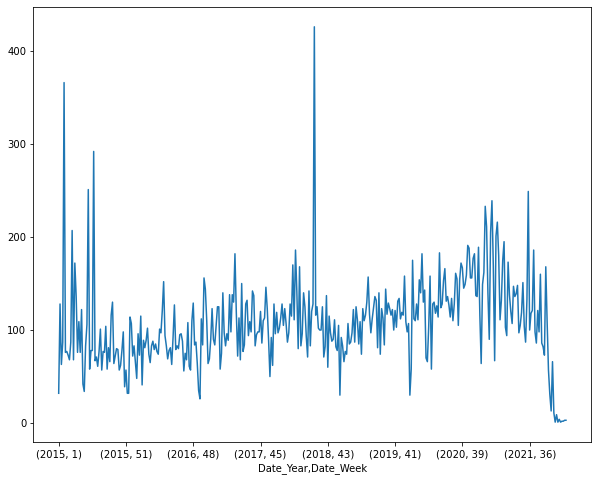

In [29]:
df_yw_c = df.groupby(['Date_Year', 'Date_Week']).size()

df_yw_c.head()

df_yw_c.plot(kind = 'line', figsize = (10, 8))

<AxesSubplot:xlabel='Date', ylabel='counts'>

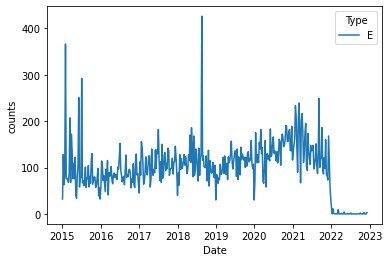

In [11]:
df_tyw_c = df.value_counts(subset = ['Type', 'Date'])

df_tyw_c.head()

df_tyw_c = df_tyw_c.to_frame('counts')
df_tyw_c = df_tyw_c.reset_index()

df_tyw_c = df_tyw_c.set_index('Date')


df_tyw_c = df_tyw_c.groupby(['Type']).resample('w').sum().reset_index()
#df_tyw_c= df_tyw_c.set_index(['Date_Year', 'Date_Week'])


                                               
sns.lineplot(data = df_tyw_c,
             x = 'Date',
             y = 'counts',
             hue = 'Type',
            #figsize = (10, 8)
            )

In [12]:
df_tyw_c.loc[df_tyw_c['Type'] == 'E', 'Type'].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            404, 405, 406, 407, 408, 409, 410, 411, 412, 413],
           dtype='int64', length=414)

Date_Year  Date_Month
2015       1             35467.0
           2             40093.5
           3             42857.0
           4             34305.0
           5             34459.0
                          ...   
2022       6             31349.0
           7             53042.5
           10            44928.0
           11            45263.0
           12            36818.0
Name: Price_m2, Length: 93, dtype: float64


<AxesSubplot:xlabel='Date_Year,Date_Month'>

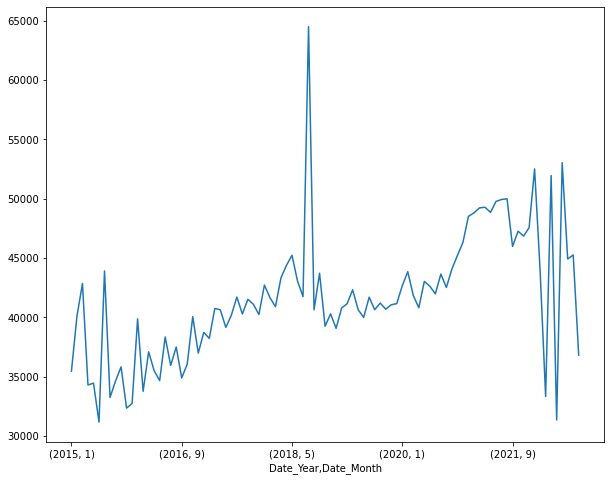

In [60]:
df_yw_AvgP = df_filt.groupby(['Date_Year', 'Date_Month'])['Price_m2'].median()

print(df_yw_AvgP)

df_yw_AvgP.plot(kind = 'line', figsize = (10, 8))